# Introduction

Recently, I was working on a [project](https://github.com/harin/dblp-data-exploration) for Exploratory Data Analysis and Visualization class, where we have chosen to analyze the trends and relationship between computer science paper from the DBLP database. One finding we found is that there is a negative correlation between title length and the number of citations. Since I recently took the Causal Inference class, this is a good opportunity to apply them and see whether shorter title length in fact causes more citations.

Note that the data was taken from https://aminer.org/citation.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from graphviz import Digraph
%matplotlib inline

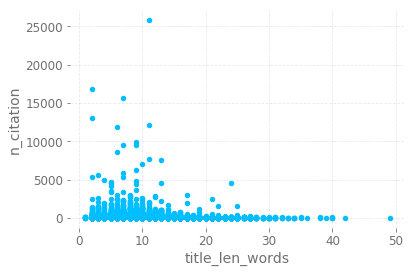

In [248]:
df = pd.read_pickle('dblp.pkl')
df['title_len_words'] = df.title.apply(lambda x: len(x.split(' ')))
df.sample(100000).plot('title_len_words', 'n_citation', kind='scatter');

To investigate whether title length causes number of citation to increase, we first need to come up with a causal graph we believe represents the system. One of the simplest graph we can have is one in which the title length effects the number of citation, but is confounded by the author. This is represented by the graph below:

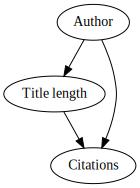

In [215]:
g = Digraph()
g.node('D', 'Title length')
g.node('Z', 'Author')
g.node('Y', 'Citations')
g.edges(['DY', 'ZD', 'ZY'])
g

In [216]:
df.shape

(3079007, 8)

There is two problems with our causal variable "Title length" is that it is not a binary variable, this is a departure from what I've learned, so the result might not be correct. Second, "Author" is a categorical data, so we have to convert them to dummy variables, which would limit how many authors we can include in our analysis.

## Data Mangling

In [217]:
df.head()

,authors,id,n_citation,references,title,venue,year,title_len_words
0,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",00127ee2-cb05-48ce-bc49-9de556b93346,0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,26
1,"[Gareth Beale, Graeme Earl]",001c58d3-26ad-46b3-ab3a-c1e557d16821,50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,11
2,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",001c8744-73c4-4b04-9364-22d31a10dbf1,50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,14
3,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",00338203-9eb3-40c5-9f31-cbac73a519ec,0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,16
4,"[Giovanna Guerrini, Isabella Merlo]",0040b022-1472-4f70-a753-74832df65266,2,NaN,Reasonig about Set-Oriented Methods in Object ...,,1998,7


In [218]:
df.shape

(3079007, 8)

In [219]:
is_list = df.authors.apply(lambda x: isinstance(x, list))

In [221]:
df[~is_list]

,authors,id,n_citation,references,title,venue,year,title_len_words
1105528,NaN,634390c1-d4cf-4192-b55f-8ade3af72a08,0,"[11e73009-08b3-4361-bd8d-89312b7cc7fa, 866260c...",Elastogram estimation using adaptive-length Sa...,biomedical engineering and informatics,2011,7
1174531,NaN,736b86b6-715c-4b3b-8d38-d6cd03709bb2,1,NaN,Pose Invariant Face Recognition by Face Synthe...,british machine vision conference,2000,7
2594452,NaN,9c4cf6a4-3d7a-4892-9acd-dc30336c73f1,1,"[1a6ecea3-bad3-4139-8c15-9a35247b8be4, 93cffd7...",An efficient intra-mode decision method for HEVC,"Signal, Image and Video Processing",2016,7
2881547,NaN,81d297e4-0b71-4f14-81e6-7fe51abd1d31,3,NaN,Durchgängiges modellbasiertes Engineering von ...,Automatisierungstechnik,2016,5


In [222]:
# remove unused columns and remove rows without authors
df = df[['authors', 'n_citation', 'title_len_words']] 
df = df[is_list]

In [223]:
df.head()

,authors,n_citation,title_len_words
0,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,26
1,"[Gareth Beale, Graeme Earl]",50,11
2,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,14
3,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,16
4,"[Giovanna Guerrini, Isabella Merlo]",2,7


In [226]:
df['num_authors'] = df.authors.apply(len)
df.num_authors.sum()

9476165

In [227]:
df = df.reset_index()

In [228]:
# unroll the authors column
rows = []
for _, row in df[is_list].iterrows():
    for author in row.authors:
        rows.append([author, row['index']])

C:\Users\harinsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [229]:
author_df = pd.DataFrame(rows)

In [230]:
author_df.head()

,0,1
0,Makoto Satoh,0
1,Ryo Muramatsu,0
2,Mizue Kayama,0
3,Kazunori Itoh,0
4,Masami Hashimoto,0


In [231]:
author_df.columns = ['author', 'index']
author_df = author_df.set_index('index') 

In [232]:
author_df.head()

,author
index,
0,Makoto Satoh
0,Ryo Muramatsu
0,Mizue Kayama
0,Kazunori Itoh
0,Masami Hashimoto


In [233]:
df = author_df.join(df)[['author', 'title_len_words', 'n_citation', 'num_authors']].reset_index()

In [234]:
df.head()

,index,author,title_len_words,n_citation,num_authors
0,0,Makoto Satoh,26.0,0.0,8.0
1,0,Ryo Muramatsu,26.0,0.0,8.0
2,0,Mizue Kayama,26.0,0.0,8.0
3,0,Kazunori Itoh,26.0,0.0,8.0
4,0,Masami Hashimoto,26.0,0.0,8.0


In [237]:
# Convert author to integers
df.author = df.author.astype('category')
df.author = df.author.cat.rename_categories(np.arange(len(df.author.cat.categories)))
df.head()

,index,author,title_len_words,n_citation,num_authors
0,0,967189,26.0,0.0,8.0
1,0,1344877,26.0,0.0,8.0
2,0,1091158,26.0,0.0,8.0
3,0,831977,26.0,0.0,8.0
4,0,1021921,26.0,0.0,8.0


In [238]:
paper_count = df[['author', 'n_citation']].groupby('author').count()

In [239]:
# filter out author with only 1 paper, not sure if this is necessary because we are not doing any matching, but
# intuitively, it is probably better to have author with paper with multiple paper length to regress on
valid_authors = paper_count[paper_count.n_citation > 1]

In [240]:
# use only author with more than one paper
df = df[df.author.isin(valid_authors.index)]

In [241]:
# remove rows without data
df = df.dropna()

In [242]:
df.shape

(8577232, 5)

In [243]:
df.author.cat.categories

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1766536, 1766537, 1766538, 1766539, 1766540, 1766541, 1766542,
            1766543, 1766544, 1766545],
           dtype='int64', length=1766546)

Still over a million author, would be impossible to do matching. Let's perform matching on a sample of authors instead.

In [244]:
def regress(n):
    author_sample = df.author.cat.categories.to_series().sample(n)
    df_sample = df[df.author.isin(author_sample)]
    df_sample.author = df_sample.author.astype(int).astype('category')
    df_sample.author = df_sample.author.cat.rename_categories(np.arange(len(df_sample.author.cat.categories)))

    X = pd.concat([pd.get_dummies(df_sample.author, prefix='author'), df_sample['title_len_words']], axis=1)
    sm.add_constant(X)
    y = df_sample['n_citation']
    model = sm.OLS(y, X)

    fit = model.fit()
    return fit

In [245]:
regress(100).conf_int().loc['title_len_words']

C:\Users\harinsa\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0   -2.130604
1    0.512479
Name: title_len_words, dtype: float64

In [246]:
regress(1000).conf_int().loc['title_len_words']

C:\Users\harinsa\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0   -3.208329
1    0.215463
Name: title_len_words, dtype: float64

# Conclusion

If OLS is a valid way to remove confounding between "Title length" and "Number of Citations" then, this experiment have not quite proven that shorter title length results in more citation, as the confidence interval of the coefficient of the title length may still be due to randomness. 

More important, we first need to verify whether OLS is in fact a good estimator for the causal effect in presence of *non-binary causal state* and *categorical confounder*. Furthermore, here we are not nearly close to the amount of data we have. Each sample we run give conflicting results, some successfully rejects the null, while other did not.
